In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Directory containing the images
data_directory = "data"

# Load images and labels
images = []
labels = []

for filename in os.listdir(data_directory):
    if filename.startswith("control"):
        labels.append(0)
    elif filename.startswith("pd"):
        labels.append(1)
    else:
        # Skip files that don't match the expected naming convention
        continue
    
    img_path = os.path.join(data_directory, filename)
    img = Image.open(img_path)
    images.append(img)

# Convert the list of images to numpy arrays
images = [np.array(img) for img in images]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

len(X_train), len(X_val)  # Display the number of images in training and validation sets


(566, 142)

In [4]:
control_size, pd_size = 0, 0
for label in labels:
    if label == 0:
        control_size += 1
    else:
        pd_size += 1
control_size, pd_size

(324, 384)

In [3]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
y_train = np.array(y_train)
y_val = np.array(y_val)


Epoch 1/20
18/18 [==============================] - 29s 1s/step - loss: 0.7062 - accuracy: 0.5972 - val_loss: 0.6469 - val_accuracy: 0.6549
Epoch 2/20
18/18 [==============================] - 15s 852ms/step - loss: 0.5022 - accuracy: 0.7527 - val_loss: 0.5623 - val_accuracy: 0.7394
Epoch 3/20
18/18 [==============================] - 14s 786ms/step - loss: 0.4277 - accuracy: 0.8180 - val_loss: 0.5821 - val_accuracy: 0.6761
Epoch 4/20
18/18 [==============================] - 14s 808ms/step - loss: 0.3992 - accuracy: 0.8127 - val_loss: 0.5453 - val_accuracy: 0.7254
Epoch 5/20
18/18 [==============================] - 14s 774ms/step - loss: 0.3558 - accuracy: 0.8587 - val_loss: 0.5840 - val_accuracy: 0.7183
Epoch 6/20
18/18 [==============================] - 14s 792ms/step - loss: 0.3434 - accuracy: 0.8693 - val_loss: 0.5913 - val_accuracy: 0.7042
Epoch 7/20
18/18 [==============================] - 14s 814ms/step - loss: 0.3127 - accuracy: 0.8852 - val_loss: 0.5709 - val_accuracy: 0.7183
Ep

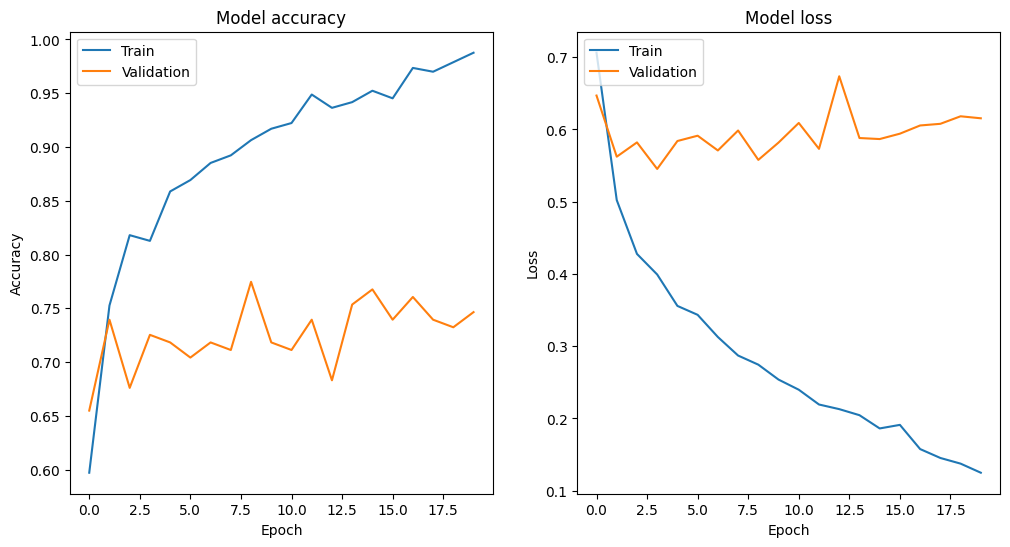

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath='/mnt/data/inception_best_model.h5', 
                                   save_best_only=True, 
                                   monitor='val_loss', 
                                   mode='min')

# Load InceptionV3 model, pretrained on imagenet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # assuming binary classification

# The model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=20, batch_size=32, 
                    callbacks=[model_checkpoint])

# Save the final model
model.save('/mnt/data/my_inception_final_model.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save plots to a file
plt.savefig('/mnt/data/training_plots.png')

plt.show()

Training with batch size 16, learning rate 0.0001, neurons 1024, dropout 0.25
Epoch 1/20
36/36 [==============================] - 30s 519ms/step - loss: 0.7158 - accuracy: 0.6060 - val_loss: 0.6009 - val_accuracy: 0.6620
Epoch 2/20
36/36 [==============================] - 16s 433ms/step - loss: 0.5101 - accuracy: 0.7385 - val_loss: 0.5808 - val_accuracy: 0.7394
Epoch 3/20
36/36 [==============================] - 15s 424ms/step - loss: 0.4581 - accuracy: 0.7756 - val_loss: 0.5673 - val_accuracy: 0.7113
Epoch 4/20
36/36 [==============================] - 15s 421ms/step - loss: 0.4225 - accuracy: 0.8180 - val_loss: 0.6215 - val_accuracy: 0.7183
Epoch 5/20
36/36 [==============================] - 16s 454ms/step - loss: 0.3867 - accuracy: 0.8251 - val_loss: 0.6093 - val_accuracy: 0.6690
Epoch 6/20
36/36 [==============================] - 16s 439ms/step - loss: 0.3466 - accuracy: 0.8569 - val_loss: 0.6236 - val_accuracy: 0.7042
Epoch 7/20
36/36 [==============================] - 16s 437ms/st

36/36 [==============================] - 14s 393ms/step - loss: 0.2404 - accuracy: 0.8852 - val_loss: 1.0368 - val_accuracy: 0.6479
Epoch 13/20
36/36 [==============================] - 14s 384ms/step - loss: 0.1893 - accuracy: 0.9276 - val_loss: 1.1704 - val_accuracy: 0.6408
Epoch 14/20
36/36 [==============================] - 13s 376ms/step - loss: 0.1335 - accuracy: 0.9611 - val_loss: 1.0076 - val_accuracy: 0.6761
Epoch 15/20
36/36 [==============================] - 15s 414ms/step - loss: 0.1612 - accuracy: 0.9329 - val_loss: 0.9870 - val_accuracy: 0.7113
Epoch 16/20
36/36 [==============================] - 13s 374ms/step - loss: 0.1341 - accuracy: 0.9558 - val_loss: 0.9017 - val_accuracy: 0.7535
Epoch 17/20
36/36 [==============================] - 13s 371ms/step - loss: 0.1238 - accuracy: 0.9523 - val_loss: 1.0538 - val_accuracy: 0.7183
Epoch 18/20
36/36 [==============================] - 14s 384ms/step - loss: 0.0814 - accuracy: 0.9735 - val_loss: 1.0219 - val_accuracy: 0.7042
Epoc

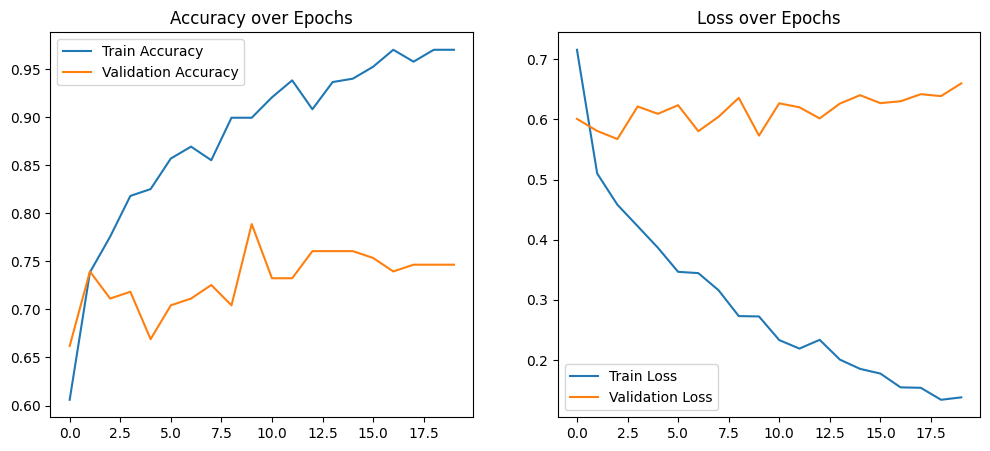

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_val, y_val are predefined and loaded correctly

# Define the hyperparameter space
batch_sizes = [16, 32, 64]
learning_rates = [1e-4, 1e-3, 1e-2]
dense_neurons = [512, 1024, 2048]
dropouts = [0, 0.25, 0.5]

# Save the best model's parameters and performance
best_accuracy = 0
best_parameters = {}
best_history = None

# Number of iterations for random search
num_iterations = 10  # Increase this for a more thorough search

# Perform random grid search
for _ in range(num_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    neurons = random.choice(dense_neurons)
    dropout_rate = random.choice(dropouts)

    print(f"Training with batch size {batch_size}, learning rate {learning_rate}, "
          f"neurons {neurons}, dropout {dropout_rate}")

    # Load the InceptionV3 base model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(neurons, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=batch_size)

    val_accuracy = np.max(history.history['val_accuracy'])
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_parameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'neurons': neurons,
            'dropout': dropout_rate
        }
        best_history = history
        model.save('/mnt/data/best_inception_model.h5')

# Print the best parameters
print(f"Best validation accuracy: {best_accuracy}")
print("Best parameters:", best_parameters)

# Plot training graphs
if best_history is not None:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Train Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()


Epoch 1/100
36/36 [==============================] - 31s 582ms/step - loss: 0.7428 - accuracy: 0.6148 - val_loss: 0.6677 - val_accuracy: 0.6761
Epoch 2/100
36/36 [==============================] - 17s 488ms/step - loss: 0.5464 - accuracy: 0.7350 - val_loss: 0.6250 - val_accuracy: 0.6901
Epoch 3/100
36/36 [==============================] - 17s 468ms/step - loss: 0.4427 - accuracy: 0.8039 - val_loss: 0.5678 - val_accuracy: 0.6901
Epoch 4/100
36/36 [==============================] - 17s 481ms/step - loss: 0.4203 - accuracy: 0.8039 - val_loss: 0.5666 - val_accuracy: 0.7465
Epoch 5/100
36/36 [==============================] - 17s 484ms/step - loss: 0.3764 - accuracy: 0.8339 - val_loss: 0.6237 - val_accuracy: 0.6831
Epoch 6/100
36/36 [==============================] - 17s 483ms/step - loss: 0.3457 - accuracy: 0.8516 - val_loss: 0.5553 - val_accuracy: 0.7676
Epoch 7/100
36/36 [==============================] - 17s 478ms/step - loss: 0.3162 - accuracy: 0.8693 - val_loss: 0.5856 - val_accuracy:

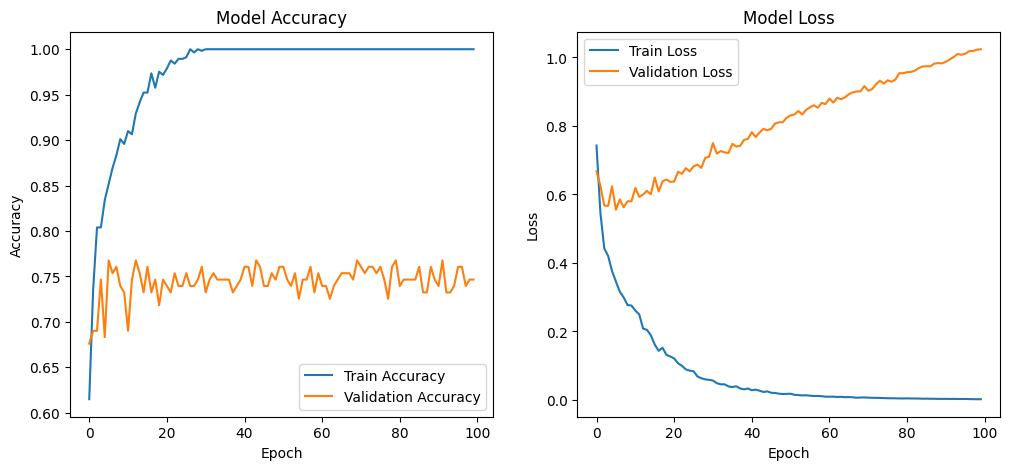

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


batch_size = 16
learning_rate = 0.0001
neurons = 1024
dropout_rate = 0.25

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(neurons, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=batch_size)

model.save('/mnt/data/trained_inception_model.h5')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


input_shape = (128, 128, 3)  
num_classes = 1  

model = Sequential([
    Conv2D(8, (5, 5), activation='relu', input_shape=input_shape),  
    MaxPooling2D((4, 4)),  
    Flatten(),
    Dense(16, activation='relu'),  
    Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=128)  # Larger batch size, fewer epochs

model.save('/mnt/data/worse_baseline_sequential_model.h5')


Epoch 1/5
5/5 [==============================] - 6s 913ms/step - loss: 0.6855 - accuracy: 0.5618 - val_loss: 0.6922 - val_accuracy: 0.5141
Epoch 2/5
5/5 [==============================] - 4s 759ms/step - loss: 0.6826 - accuracy: 0.5530 - val_loss: 0.6921 - val_accuracy: 0.5141
Epoch 3/5
5/5 [==============================] - 4s 757ms/step - loss: 0.6808 - accuracy: 0.5495 - val_loss: 0.6919 - val_accuracy: 0.5141
Epoch 4/5
5/5 [==============================] - 4s 758ms/step - loss: 0.6793 - accuracy: 0.5495 - val_loss: 0.6916 - val_accuracy: 0.5141
Epoch 5/5
5/5 [==============================] - 4s 755ms/step - loss: 0.6782 - accuracy: 0.5495 - val_loss: 0.6914 - val_accuracy: 0.5141


In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = '/mnt/data/trained_inception_model.h5'

# Load the model
loaded_model = load_model(model_path)

# After loading, you can use the model to make predictions, evaluate, etc.
# For example, to get a summary of the model:
loaded_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

 batch_normalization_104 (Batch  (None, 13, 13, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 13, 13, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 13, 13, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activatio

 conv2d_114 (Conv2D)            (None, 13, 13, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 13, 13, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 13, 13, 48)  144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 13, 13, 96)  288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_128 (Conv2D)            (None, 6, 6, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 6, 6, 128)   384         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 6, 6, 128)    114688      ['activation_128[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_138 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 6, 6, 160)    179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 6, 6, 160)   480         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_13

 batch_normalization_149 (Batch  (None, 6, 6, 160)   480         ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 6, 6, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 6, 6, 160)    179200      ['activation_149[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 6, 6, 160)   480         ['conv2d_145[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 6, 6, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 6, 6, 192)    258048      ['activation_159[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 6, 6, 192)   576         ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_160 (Batch  (None, 6, 6, 192)   576         ['conv2d_160[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 6, 6, 192)   576         ['conv2d_168[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_164 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_164[0][0]']
                                                                                                  
 activation_168 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_168[0][0]']
                                                                                                  
 conv2d_165 (Conv2D)            (None, 2, 2, 320)    552960      ['activation_164[0][0]']         
          

                                                                                                  
 activation_176 (Activation)    (None, 2, 2, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 2, 2, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 batch_normalization_178 (Batch  (None, 2, 2, 192)   576         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_170 (Activation)    (None, 2, 2, 320)    0           ['batch_normalization_170[0][0]']
                                                                                                  
 mixed9_0 

 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 2, 2, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 2, 2, 768)    0           ['activation_181[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 concatenate_3 (Concatenate)    (None, 2, 2, 768)    0           ['activation_185[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 activatio